In [1]:
#load library
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sqlalchemy as sqla
from io import StringIO
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
import plotly.offline as offline
import plotnine as p9
from collections import Counter
from sklearn.neighbors import LocalOutlierFactor
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image 
import seaborn as sns
import joypy
import warnings
warnings.filterwarnings('ignore')
#credentials
plotly.tools.set_credentials_file(username='zhenhangliu', api_key='vNe3aFwBSfb1pV4LNLwO')
mapbox_access_token = 'pk.eyJ1IjoiemhlbmhhbmdsaXUiLCJhIjoiY2pvemZremhyMG1sOTN2cDRiMjJ4bmR0MSJ9.UHRGP-HIJHJJA7np0AxlbQ'
#connection to sqlite
conn = sqla.create_engine('sqlite:///yelp.sqlite')


In [2]:
business=pd.read_sql_table("business",conn)
business.head()

,business_id,address,categories,city,is_open,latitude,longitude,name,neighborhood,postal_code,review_count,stars,state
0,Apn5Q_b6Nz61Tq4XzPdf9A,1314 44 Avenue NE,Restaurants,Calgary,1,51.091813,-114.031675,Minhas Micro Brewery,None,T2E 6L6,24,4.0,AB
1,AjEbIBw6ZFfln7ePHha9PA,None,Restaurants,Henderson,0,35.960734,-114.939821,CK'S BBQ & Catering,None,89002,3,4.5,NV
2,O8S5hYJ1SMc8fA4QBtVujA,1335 rue Beaubien E,Restaurants,Montréal,0,45.540503,-73.599300,La Bastringue,Rosemont-La Petite-Patrie,H2G 1K7,5,4.0,QC
3,bFzdJJ3wp3PZssNEsyU23g,211 W Monroe St,FinancialServices,Phoenix,1,33.449999,-112.076979,Geico Insurance,None,85003,8,1.5,AZ
4,8USyCYqpScwiNEb58Bt6CA,2005 Alyth Place SE,Shopping,Calgary,1,51.035591,-114.027366,Action Engine,None,T2H 0N5,4,2.0,AB


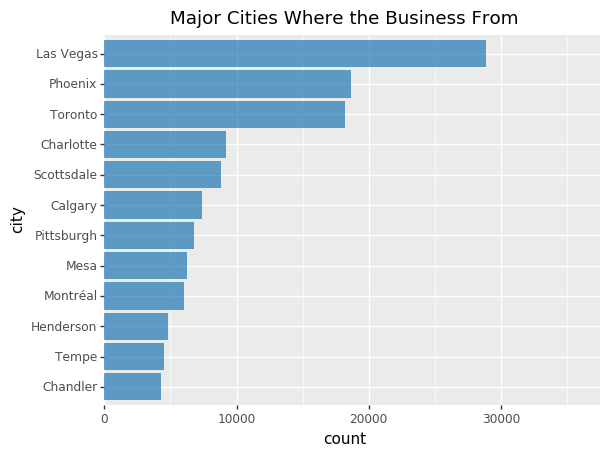

<ggplot: (-9223372029309734610)>

In [3]:
#which cities the major data from
major_count=business.city.value_counts()[business.city.value_counts(ascending=False)>4000].sort_values(ascending=True)
major_city=pd.DataFrame({"city":major_count.index,"count":major_count.values})
p9.ggplot(major_city,p9.aes(x="city",y="count"))+p9.geom_bar(stat="identity",fill="C0",alpha=0.7)+p9.coord_flip()\
    +p9.scale_x_discrete (limits =major_city.city)+p9.labs(title="Major Cities Where the Business From")\
    +p9.scale_y_continuous(expand=[0,0,0.3,0])

In [4]:
#visualize on map 
map_data=business[business["longitude"].notnull() & business["latitude"].notnull()]
data = [
    go.Scattermapbox(
        lat=map_data["latitude"],
        lon=map_data["longitude"],
        mode='markers',
        marker=dict(
            opacity = 0.3,
            size=7,
        ),
        text=map_data["name"]+"<br>Stars: "+map_data["stars"].astype(str)\
        +"<br>Review: "+map_data["review_count"].astype(str)+"<br>"+map_data["address"].fillna('')+"<br>"\
        +map_data["city"].fillna('')+","+map_data["state"].fillna('')+" "+map_data["postal_code"].fillna(''),
    ) 
]
layout = go.Layout(
    autosize=True,
    title="Business on Map",
    hovermode='closest',
    mapbox=dict(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=dict(
            lat=map_data["latitude"].median(),
            lon=map_data["longitude"].median()
        ),
        pitch=0,
        zoom=0,
        style= 'mapbox://styles/zhenhangliu/cjp0dy6xg05rt2rod3gviy342'
    ),
    legend=dict(orientation="h")
)
fig=dict(data=data,layout=layout)

py.iplot(fig,filename="Yelp Data map 1")

In [5]:
#detect mislabeled business
grouped_city=map_data[map_data["city"].notnull()].groupby("city")
def get_outlier(data):
    """The function create append a new column "outlier" to the input dataframe, which indicates
        whether a business is mislabeled. 
    Args:
        data(pd.DataFrame): business that need to verify whether it is mislabeled.
    Returns:
        data(pd.DataFrame): same as input but a new column indicates whether a business is mislabeled.
    """
    data.reset_index(drop=True,inplace=True)
    if len(data.index)>=10:
        number_neighbors=round(len(data.index)/10)
    elif len(data.index)<=2:
        data["outlier"]=1
        return data
    else:
        number_neighbors=len(data.index)
    LOF = LocalOutlierFactor(n_neighbors=number_neighbors,metric="euclidean",contamination=0.0004)
    outlier=pd.DataFrame(LOF.fit_predict(data[["latitude","longitude"]]))
    data.reset_index(inplace=True,drop=True)
    data["outlier"]=outlier
    data.index.name=None
    return data
map_data=grouped_city.apply(get_outlier)
#visualize mislabel business
data = [
    go.Scattermapbox(
        lat=business["latitude"],
        lon=business["longitude"],
        mode='markers',
        marker=dict(
            opacity = 0.3,
            size=7,
            color="#ff7f0e" if business["outlier"][0]==-1 else "#1f77b4"
        ),
        text=business["name"]+"<br>Stars: "+business["stars"].astype(str)\
        +"<br>Review: "+business["review_count"].astype(str)+"<br>"+business["address"].fillna('')+"<br>"\
        +business["city"].fillna('')+","+business["state"].fillna('')+" "+business["postal_code"].fillna(''),
        name="with Incorrect Geographic Information",
        showlegend=True if business["outlier"].iloc[0]==-1 else False,
    ) for business in [map_data[map_data["outlier"]==i] for i in map_data["outlier"].unique()[::-1]]
]

layout = go.Layout(
    autosize=True,
    title="Bussines with Incorrect Geographic Information Provided by Yelp",
    hovermode='closest',
    mapbox=dict(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=dict(
            lat=map_data["latitude"].median(),
            lon=map_data["longitude"].median()
        ),
        pitch=0,
        zoom=0,
        style= 'mapbox://styles/zhenhangliu/cjp0dy6xg05rt2rod3gviy342'
    ),
    legend=dict(orientation="h")
)
fig=dict(data=data,layout=layout)
py.iplot(fig,filename="Yelp Data map2")

In [6]:
#get the percentage of mislabeled business.
sum(map_data.outlier==-1)/len(map_data.index)

0.0032400729679280503

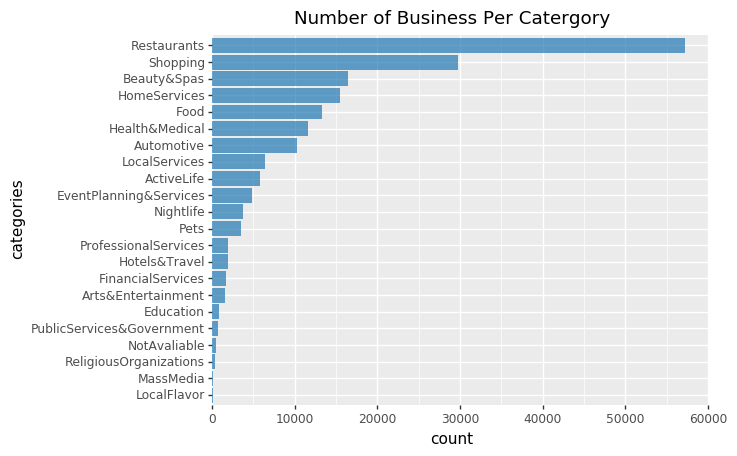

<ggplot: (7546932558)>

In [7]:
#number of business per catergory
sorted_cate=business.categories.value_counts(ascending=True).index
p9.ggplot(business,p9.aes("categories"))+p9.geom_bar(fill="C0",alpha=0.7)+p9.coord_flip()\
    +p9.scale_x_discrete (limits =sorted_cate)+p9.labs(title="Number of Business Per Catergory")\
    +p9.scale_y_continuous(expand=[0,0],limits=[0,60000])

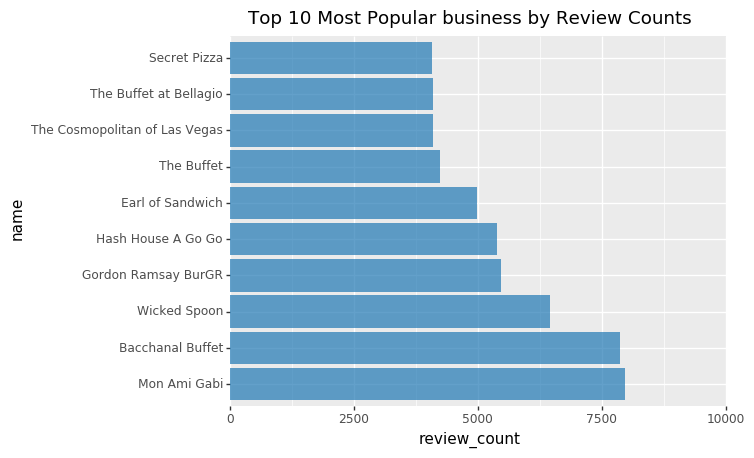

<ggplot: (7548871309)>

In [ ]:
#most popular business by Review Counts
top_10_review=business.loc[business.review_count.sort_values(ascending=False).index,:][:10]
p9.ggplot(top_10_review,p9.aes(x="name",y="review_count"))+p9.geom_bar(stat="identity",fill="C0",alpha=0.7)+p9.coord_flip()\
    +p9.scale_x_discrete (limits =top_10_review.name)+p9.labs(title="Top 10 Most Popular business by Review Counts")\
    +p9.scale_y_continuous(expand=[0,0],limits=[0,10000])

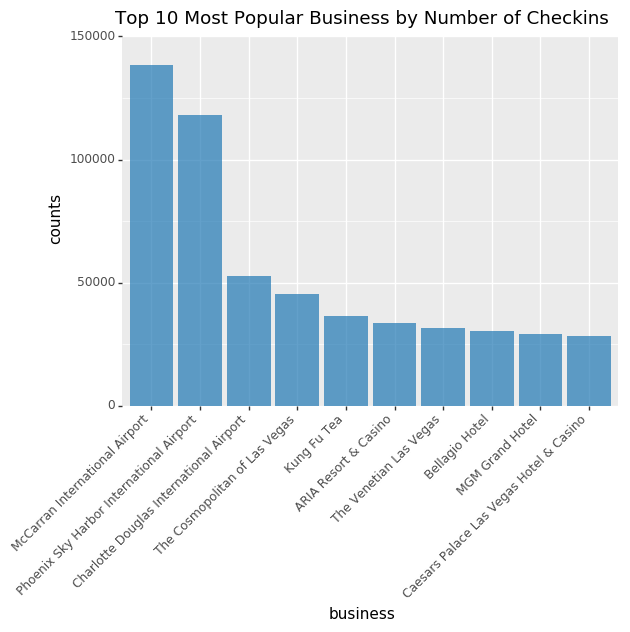

<ggplot: (-9223372029309808773)>

In [ ]:
checkin=pd.read_sql_table("checkin",conn)
#most popular business by number of checkins
checkin_top10=checkin.groupby("business_id")["checkins"].sum().sort_values(ascending = False)[:10]
top10names = [list(business.name[business.business_id == i]) for i in checkin_top10.index]
checkin_top10_df = pd.DataFrame({'business': [i[0] for i in top10names], 'counts': checkin_top10})
p9.ggplot(checkin_top10_df, p9.aes(x='business', y='counts'))+p9.geom_bar(stat='identity',fill="C0",alpha=0.7) + \
    p9.theme(axis_text_x=p9.element_text(rotation=45, hjust=1))+\
    p9.labs(title="Top 10 Most Popular Business by Number of Checkins")+\
    p9.scale_x_discrete (limits =checkin_top10_df.business)+p9.scale_y_continuous(expand=[0,0],limits=[0,150000])

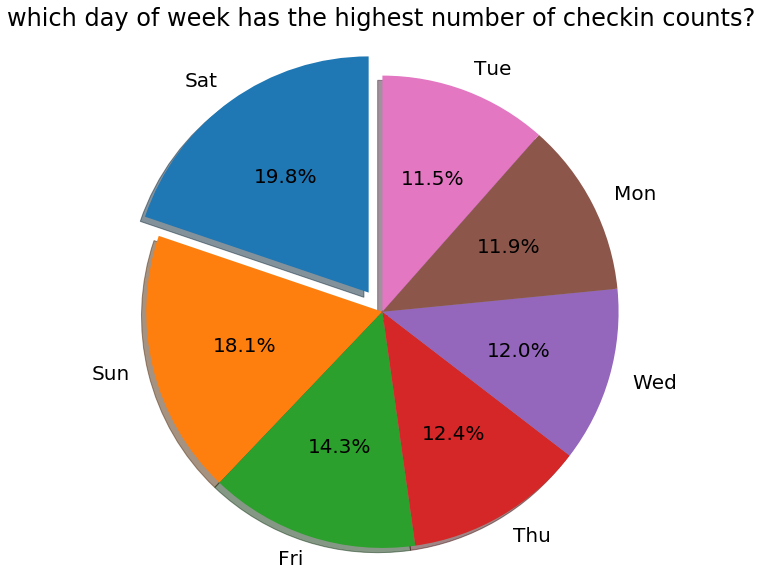

In [ ]:
#which day of week has the highest number of checkin counts?
checkin_dow_total = checkin.groupby('weekday')['checkins'].sum().sort_values(ascending = False)
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = list(checkin_dow_total.index)
sizes = np.array(checkin_dow_total/sum(checkin_dow_total)).round(4)*100
explode = (0.1, 0, 0, 0, 0, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')
plt.rcParams.update({'font.size': 20})
fig1, ax1 = plt.subplots(figsize=(10, 10))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title("which day of week has the highest number of checkin counts?")
plt.show()

#### Total checkin counts in each hour of a day

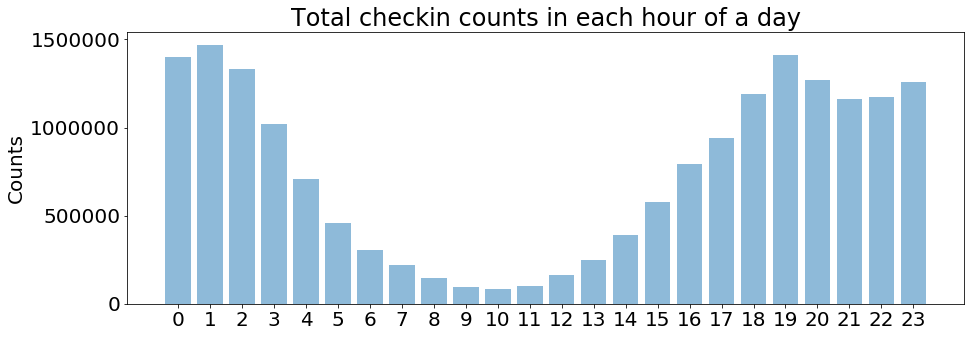

In [ ]:
#Total checkin counts in each hour of a day
checkin_hours_total = checkin.groupby("hour")['checkins'].sum()
hour = checkin_hours_total.index
counts = list(checkin_hours_total)
fig2, ax1 = plt.subplots(figsize=(15, 5))
plt.bar(hour, counts, align='center', alpha=0.5)
plt.xticks(hour)
plt.ylabel('Counts')
plt.title('Total checkin counts in each hour of a day')
plt.show()

> From the plot above, the peak of check in is between 7pm to 2am, and only very few checkins during the morning, which is kind of counter intuitive. Some thing can explain this is that, the data we are analyzing are from metropolitan areas and the businesses that people like to are airport, casino, and hotels. These business tend to open until late night. 

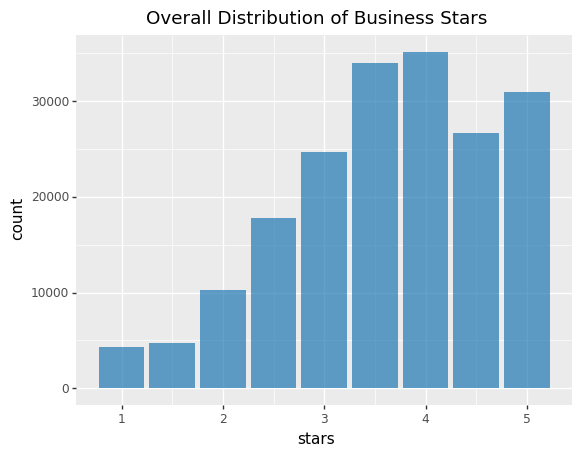

<ggplot: (7541937486)>

In [ ]:
#Overall Distribution of Business Stars
p9.ggplot(business,p9.aes("stars"))+p9.geom_bar(fill="C0",alpha=0.7)\
    +p9.labs(title="Overall Distribution of Business Stars")

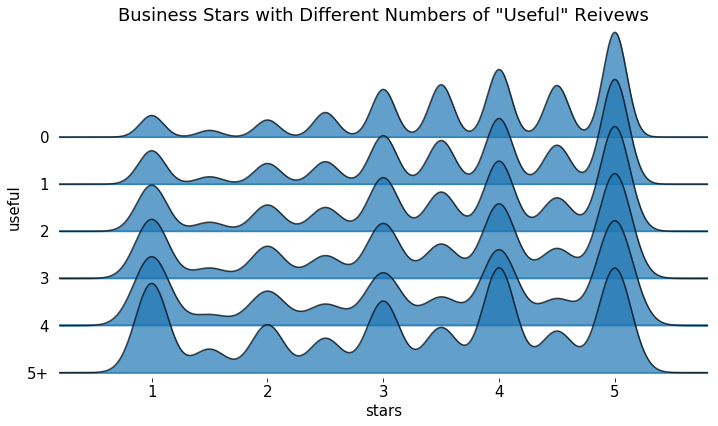

In [ ]:
#get business stars for different usefuls 
useful_stars=pd.read_sql_query("select business_id,stars,useful from review",conn)
useful_stars.drop(useful_stars[useful_stars.useful==-1].index,inplace=True)
useful_stars.loc[useful_stars.useful>4,"useful"]="5+"
starsByUseful=(round(useful_stars.groupby(["business_id","useful"]).mean()*2)/2).reset_index("useful")
starsByUseful.useful=starsByUseful.useful.astype("str")

#plot the denstiy rigde
plt.rcParams.update({'font.size': 15})
fig, axes = joypy.joyplot(starsByUseful,by="useful",ylim="own",figsize=(10,6),\
                         title="Business Stars with Different Numbers of \"Useful\" Reivews",alpha=0.7)
axes[-1].set_xlabel("stars")
fig.text(0, 0.5, 'useful', va='center', rotation='vertical')
plt.show()

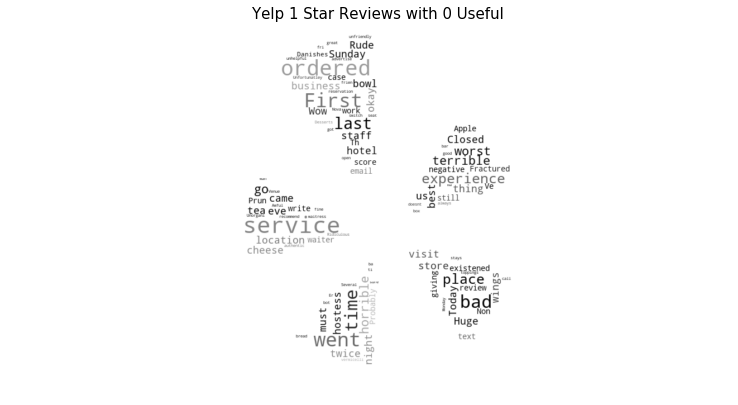

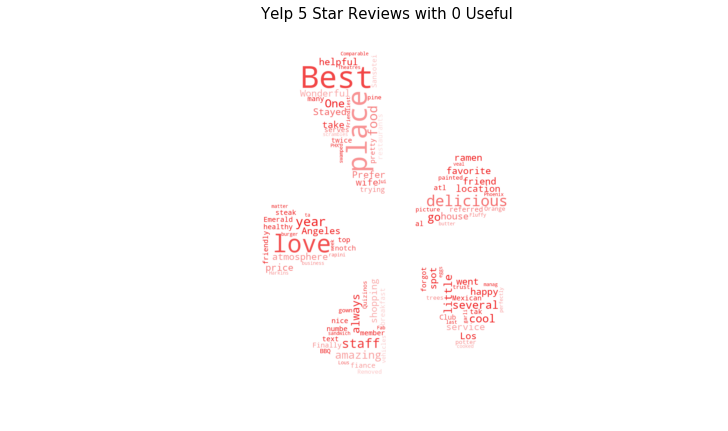

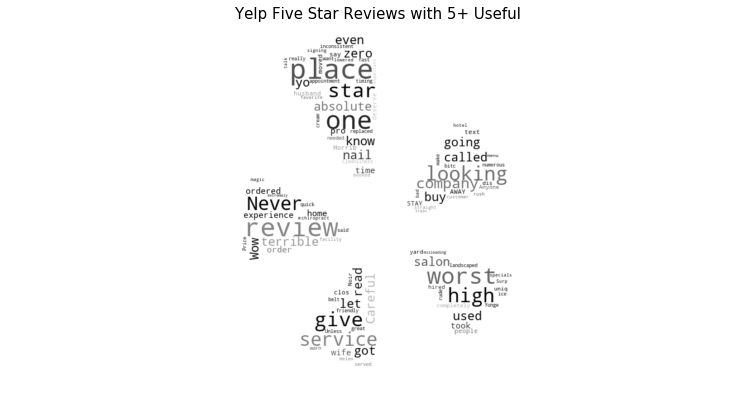

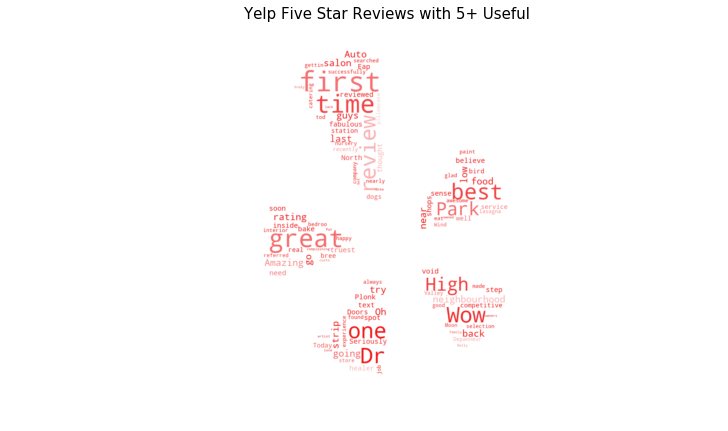

In [ ]:
#reviews with 0 useful 
onestar_review_0=pd.read_sql_query("select text from review  where stars=1 and useful=0",conn)
fivestar_review_0=pd.read_sql_query("select text from review  where stars=5 and useful=0" ,conn)
#reviews with 5+ useful 
onestar_review_1=pd.read_sql_query("select text from review  where stars=1 and useful>=5",conn)
fivestar_review_1=pd.read_sql_query("select text from review  where stars=5 and useful>=5" ,conn)

#function for drawing wordclouds 
def draw_wordcloud(review,star,no_useful=True):
    """The function draw world from reviews
    Args:
        review(pd.DataFrame): reviews for worldcloud
        star(int): stars of reviews
        no_useful(boolean): indicates whether the reivews are useful
    """
    stopwords=set(STOPWORDS)
    if star==5:
        mask=np.array(Image.open("images/yelp.jpeg"))
    else:
        mask=np.array(Image.open("images/yelp.png"))
    image_colors=ImageColorGenerator(mask)
    wc=WordCloud(background_color='white',max_words=100,mask=mask, stopwords=stopwords)
    wc.generate(str(review))
    plt.figure(figsize=[12,12])
    plt.imshow(wc.recolor(color_func=image_colors),interpolation='bilinear')
    plt.axis("off")
    if no_useful==True:
        plt.title("Yelp {} Star Reviews with 0 Useful".format(star),fontdict={'fontsize':15})
    else:
        plt.title("Yelp Five Star Reviews with 5+ Useful".format(star),fontdict={'fontsize':15})
    plt.show()
#draw word clouds
draw_wordcloud(onestar_review_0,1)
draw_wordcloud(fivestar_review_0,5)
draw_wordcloud(onestar_review_1,1,False)
draw_wordcloud(fivestar_review_1,5,False)